# Modelo

In [17]:
# LIBRERÍAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib
import os

In [18]:
# Cargar dataset preprocesado y codificado
df = pd.read_csv("C:/Users/alons/Desktop/Tesis_SIEM_ML/data/processed/logs_unificados_limpios.csv")
print("Datos cargados:", df.shape)
print(df.head())

Datos cargados: (856808, 15)
                @timestamp  host.ip  rule.name  rule.category  \
0  2024-09-29 12:06:47.000     2313          2              1   
1  2024-09-27 12:06:15.000     2395          2             20   
2  2024-09-27 07:56:15.000     1471          2             18   
3  2024-09-27 07:56:15.000     1471          2              7   
4  2024-09-26 16:52:33.000     2376          2             20   

   rule.description  file.path  file.hash.md5  file.hash.sha256  virus.name  \
0                11       1821           3288              4068         469   
1                 8       4609           2717              2619         260   
2                 8       1564           2221              1596         331   
3                 8       1564           2221              1596         332   
4                 8       4991            182              4450         359   

   danger.type  source  hour  dayofweek  month  year  
0           39       1    12          6      9  20

In [19]:
# PREPROCESAMIENTO PARA MODELOS
# Eliminar columnas no útiles para el modelo supervisado
columnas_a_eliminar = ['@timestamp', 'file.path', 'file.hash.md5', 'file.hash.sha256',
                       'virus.name', 'rule.description', 'host.hostname', 'source']
df_clean = df.drop(columns=columnas_a_eliminar, errors='ignore')

# Guardar y codificar la etiqueta multiclase original
target = 'danger.type'
le_target = LabelEncoder()
df_clean[target] = le_target.fit_transform(df_clean[target])
joblib.dump(le_target, "C:/Users/alons/Desktop/Tesis_SIEM_ML/models/label_encoder_danger_type.pkl")

# Codificación de variables categóricas
cat_cols = df_clean.select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)
# Entrenamiento de modelo supervisado (Random Forest)
X = df_encoded.drop(columns=[target])
y = df_encoded[target]


Reporte de Clasificación - Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    116128
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           5       1.00      1.00      1.00         1
           6       0.00      0.00      0.00         3
          10       0.93      0.62      0.74        21
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         2
          21       0.67      0.44      0.53         9
          23       0.00      0.00      0.00         2
          24       0.00      0.00      0.00         1
          26       0.00      0.00      0.00         0
          27       0.00      0.00      0.00         0
          28       0.00      0.00      0.00         1
          32       0.00      0.00     

c:\Users\alons\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\alons\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\alons\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

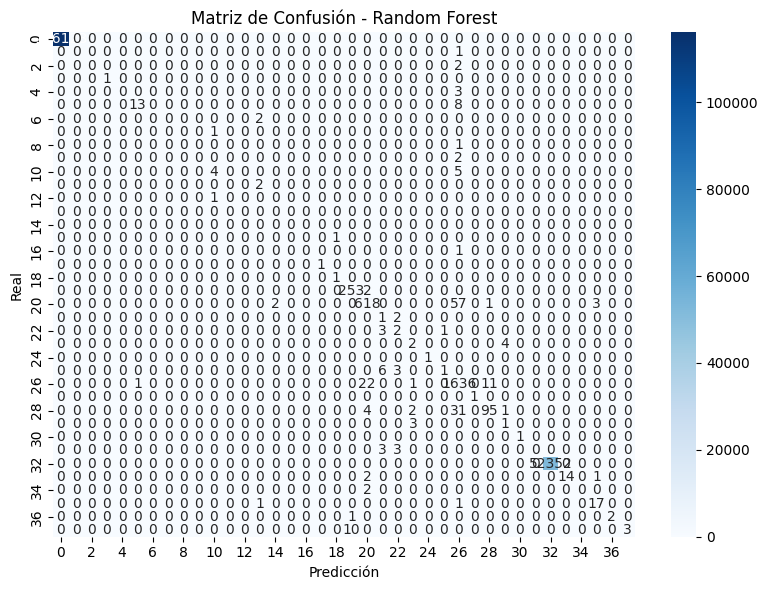

['C:/Users/alons/Desktop/Tesis_SIEM_ML/models/rf_model_clasificacion.pkl']

In [20]:
#ENTRENAMIENTO SUPERVISADO (Random Forest)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluación
y_pred = rf_model.predict(X_test)
print("\nReporte de Clasificación - Random Forest:")
print(classification_report(y_test, y_pred))

# Visualización de matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# Guardar modelo
joblib.dump(rf_model, "C:/Users/alons/Desktop/Tesis_SIEM_ML/models/rf_model_clasificacion.pkl")

In [21]:
# DETECCIÓN NO SUPERVISADA (Isolation Forest)
iso_model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_model.fit(X_train)

# Predicción: -1 = anómalo, 1 = normal
y_iso_pred = iso_model.predict(X_test)
df_anomalias = pd.DataFrame(X_test.copy())
df_anomalias["anomaly_score"] = y_iso_pred

# Conteo
print("\nResultados de Detección No Supervisada (Isolation Forest):")
print(df_anomalias["anomaly_score"].value_counts())

# Guardar modelo no supervisado
joblib.dump(iso_model, "C:/Users/alons/Desktop/Tesis_SIEM_ML/models/isolation_forest_model.pkl")


Resultados de Detección No Supervisada (Isolation Forest):
anomaly_score
 1    162978
-1      8384
Name: count, dtype: int64


['C:/Users/alons/Desktop/Tesis_SIEM_ML/models/isolation_forest_model.pkl']

In [22]:
# INFERENCIA SOBRE NUEVOS LOGS
# Cargar nuevos logs
df_nuevos = pd.read_csv("C:/Users/alons/Desktop/Tesis_SIEM_ML/data/processed/logs_unificados_limpios.csv")

# Preprocesar columnas igual que entrenamiento
df_nuevos_clean = df_nuevos.drop(columns=columnas_a_eliminar, errors='ignore')
df_nuevos_clean[target] = le_target.transform(df_nuevos_clean[target])
df_nuevos_encoded = pd.get_dummies(df_nuevos_clean, columns=df_nuevos_clean.select_dtypes(include=['object']).columns)

# Reindexar columnas para que coincidan con el entrenamiento
df_nuevos_encoded = df_nuevos_encoded.reindex(columns=X.columns, fill_value=0)

# Predicción supervisada
df_nuevos['predicted_danger_type'] = le_target.inverse_transform(rf_model.predict(df_nuevos_encoded))

# Predicción no supervisada
df_nuevos['is_anomalous'] = iso_model.predict(df_nuevos_encoded)
df_nuevos['is_anomalous'] = df_nuevos['is_anomalous'].map({1: 'Normal', -1: 'Anómalo'})

# Guardar resultados
df_nuevos.to_csv("C:/Users/alons/Desktop/Tesis_SIEM_ML/data/processed/logs_predicciones_completas.csv", index=False)
print("\nInferencia completada. Resultados guardados.")


Inferencia completada. Resultados guardados.
